## Filter Global stochastic Tropical Cyclones (Nakajo et al., 2014) that affect the site


inputs required
  * Storm tracks (Nakajo_tracks file)
  * longitude and latitude of the site (location of the waves record)
  * radius for TCs selection (º)


Nakajo, S., Mori, N., Yasuda, T., & Mase, H. (2014). Global stochastic tropical cyclone model based on principal component analysis and cluster analysis. Journal of Applied Meteorology and Climatology, 53(6), 1547–1577. https://doi.org/10.1175/JAMC-D-13-08.1

In [9]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.util.operations import GetUniqueRows
from teslakit.storms import Extract_Circle_Nakajo, SortCategoryCount



## Database and Site parameters

In [10]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('GUAM')


In [11]:
# --------------------------------------
# load data and set parameters

xds_Nakajo = db.Load_TCs_Nakajo()  # Nakajo simulations

# wave point longitude and latitude
pnt_lon = 144.5
pnt_lat = 13.5

# radius for TCs selection (º)
r1 = 14
r2 = 4



## Synthetic TCs - Category Change Probabilities

In [12]:
# --------------------------------------
# Select Nakajo TCs inside circle

# dictionary with needed variable names
d_vns = {
    'longitude':'ylon_TC',
    'latitude':'ylat_TC',
    'pressure':'yCPRES',
}

# Extract TCs inside R=14 and positions
_, xds_in_r1 = Extract_Circle_Nakajo(xds_Nakajo, pnt_lon, pnt_lat, r1, d_vns)

# Extract TCs inside R=4 and positions
_, xds_in_r2 = Extract_Circle_Nakajo(xds_Nakajo, pnt_lon, pnt_lat, r2, d_vns)

print(xds_in_r1)
print()
print(xds_in_r2)


<xarray.Dataset>
Dimensions:       (storm: 179963)
Coordinates:
  * storm         (storm) int64 3 4 5 6 8 ... 999986 999988 999990 999991 999997
Data variables:
    pressure_min  (storm) float64 1e+03 1.01e+03 983.2 ... 1.007e+03 1.001e+03
    category      (storm) int64 0 0 1 1 5 5 3 0 1 0 1 ... 1 3 4 1 5 3 3 2 2 0 0
Attributes:
    point_lon:  144.5
    point_lat:  13.5
    point_r:    14

<xarray.Dataset>
Dimensions:       (storm: 56745)
Coordinates:
  * storm         (storm) int64 22 50 52 53 58 ... 999972 999975 999977 999986
Data variables:
    pressure_min  (storm) float64 980.8 966.3 944.0 ... 997.3 1.007e+03 951.5
    category      (storm) int64 1 2 4 2 1 3 1 1 2 4 4 ... 2 0 5 3 4 1 0 1 1 0 3
Attributes:
    point_lon:  144.5
    point_lat:  13.5
    point_r:    4


In [13]:
# --------------------------------------
# Calculate Syntethic TCs category change probabilities

# Get storm category inside both circles
n_storms = len(xds_in_r1.storm)
categ_r1r2 = np.empty((n_storms, 2))
for i in range(len(xds_in_r1.storm)):

    # category inside R1
    storm_in_r1 = xds_in_r1.isel(storm=[i])
    storm_id = storm_in_r1.storm.values[0]
    storm_cat_r1 = storm_in_r1.category

    # category inside R2
    if storm_id in xds_in_r2.storm.values[:]:
        storm_in_r2 = xds_in_r2.sel(storm=[storm_id])
        storm_cat_r2 = storm_in_r2.category
    else:
        storm_cat_r2 = 9  # no category 

    # store categories
    categ_r1r2[i,:] = [storm_cat_r1, storm_cat_r2]


# count category changes and sort it
categ_count = GetUniqueRows(categ_r1r2)
categ_count = SortCategoryCount(categ_count)

# calculate probability
m_count = np.reshape(categ_count[:,2], (6,-1)).T
m_sum = np.sum(m_count,axis=0)

probs = m_count.astype(float)/m_sum.astype(float)
probs_cs = np.cumsum(probs, axis=0)

# store output using xarray
xds_categ_cp = xr.Dataset(
    {
        'category_change_count': (('category','category'), m_count[:-1,:]),
        'category_change_sum': (('category'), m_count[-1,:]),
        'category_change_probs': (('category','category'), probs[:-1,:]),
        'category_nochange_probs': (('category'), probs[-1,:]),
        'category_change_cumsum': (('category','category'), probs_cs[:-1,:]),
    },
    coords = {
        'category': [0,1,2,3,4,5]
    }
)
print(xds_categ_cp)

db.Save_TCs_probs_synth(xds_categ_cp)


<xarray.Dataset>
Dimensions:                  (category: 6)
Coordinates:
  * category                 (category) int64 0 1 2 3 4 5
Data variables:
    category_change_count    (category, category) int64 5044 6357 ... 0 4398
    category_change_sum      (category) int64 38663 41411 13702 12294 9575 7573
    category_change_probs    (category, category) float64 0.1154 ... 0.2561
    category_nochange_probs  (category) float64 0.8846 0.7985 ... 0.4337 0.441
    category_change_cumsum   (category, category) float64 0.1154 ... 0.559


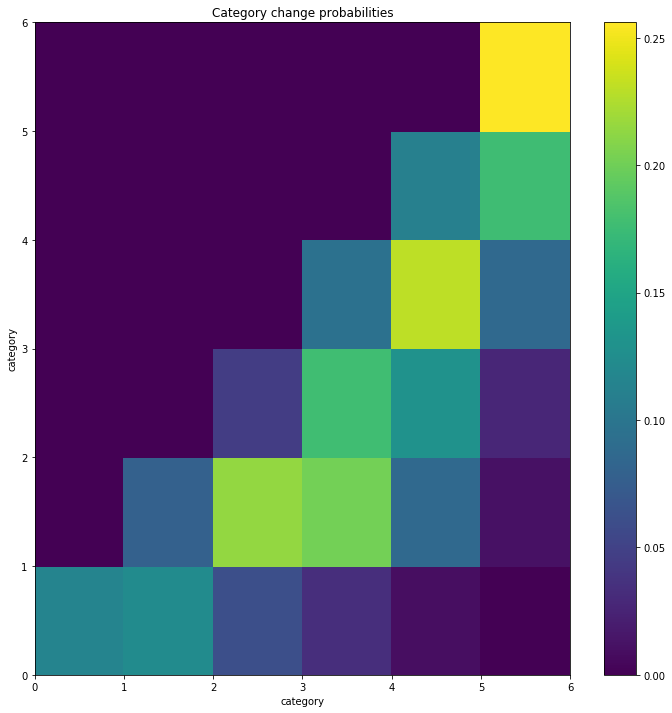

[[0.11540486 0.12257057 0.0615217  0.03334402 0.00905879 0.00034937]
 [0.         0.07897578 0.21453339 0.2011462  0.0861944  0.01187842]
 [0.         0.         0.04522489 0.17734049 0.13089954 0.02759986]
 [0.         0.         0.         0.09546329 0.23009331 0.08681728]
 [0.         0.         0.         0.         0.11006432 0.17631303]
 [0.         0.         0.         0.         0.         0.25608478]]


In [17]:
# plot category change probabilities

cp = xds_categ_cp.category_change_probs.values[:]
cs = xds_categ_cp.category.values[:]

fig, axes = plt.subplots(figsize=(12,12))
axes.set_title('Category change probabilities')
axes.set_xlabel('category')
axes.set_ylabel('category')
pc=axes.pcolor(cp)
fig.colorbar(pc)

plt.show()
